# Predicting age of a child by looking at a hand Xray
The goal of this project is to identify the age of a child from an X-ray of their hand. This data was part of a competition http://rsnachallenges.cloudapp.net/competitions/4. We will build a model inspired by the one used by the winners of the competition. You will also borrow ideas from this fast.ai notebook. https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

## Data

To get the data you can install the kaggle api using: <br/>
`pip install kaggle` <br/>
To get the dataset you can use this command line. (If you don't provide a path you will find your data in /home/user/.kaggle/datasets/kmader/rsna-bone-age/ )<br/>
`kaggle datasets download -d kmader/rsna-bone-age -p PATH` <br/>

In [3]:
PATH = Path("/data2/yinterian/rsna-bone-age/")
list(PATH.iterdir())

[PosixPath('/data2/yinterian/rsna-bone-age/model.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/rsna-bone-age.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-550'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.zip'),
 PosixPath('/data2/yinterian/rsna-bone-age/model003.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/model001.pth'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-training-dataset.csv'),
 PosixPath('/data2/yinterian/rsna-bone-age/boneage-test-dataset')]

In [4]:
! head /data2/yinterian/rsna-bone-age/boneage-training-dataset.csv

id,boneage,male
1377,180,False
1378,12,False
1379,94,False
1380,120,True
1381,82,False
1382,138,True
1383,150,True
1384,156,True
1385,36,True


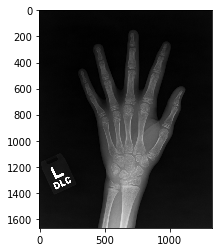

In [5]:
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))  #.astype(np.float32)/255
plt.imshow(im, cmap='gray')

In [6]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(1668, 1323, 3)

In [7]:
# let's look at the typical size of these images
path = PATH/"boneage-training-dataset"
files = list(path.iterdir())[:200]
dims = [cv2.imread(str(p)).shape for p in files]
dims[:10]

[(1818, 1468, 3),
 (1776, 1412, 3),
 (1935, 1657, 3),
 (1478, 955, 3),
 (1622, 1300, 3),
 (1804, 1303, 3),
 (1526, 1132, 3),
 (2570, 2040, 3),
 (1494, 1104, 3),
 (1673, 1304, 3)]

In [8]:
ratios = [x[0]/x[1] for x in dims]

Here is a presentation with EDA on this data
https://alxndrkalinin.github.io/pdf/2017-12_CFT_BoneAge.pdf

## Data augmentation
The winners of the competition used real-time image augmentation consisting of horizontal/vertical translation, zoom, and rotation of 20 percent/degrees as well as horizontal flip. They use 500x500 images.

In [9]:
# modified from fast.ai
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def random_crop(x, target_r, target_c):
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Center crop, resize, horizontal and vertical translations

In [ ]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
path = PATH/"boneage-training-dataset/9977.png"
im = cv2.imread(str(path))
im = center_crop(im)
im = cv2.resize(im, (550, 550))
im = random_crop(im, 500, 500)
plt.imshow(im, cmap='gray')

### Random Rotation (-10, 10) 

In [ ]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot, cmap='gray')

### Horizontal Flip

In [ ]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

## Split train and validation

In [10]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

## Saving a resized dataset

In [ ]:
# Do this to save time at training.
PATH_550 = PATH/"boneage-550"
PATH_550.mkdir()

In [ ]:
def get_a_crop(path, sz=550):
    im = cv2.imread(str(path))
    r,c,_ = im.shape
    pad = abs(r-c)//4
    if r > c :
        im2 = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_REFLECT)
    else:
        im2 = cv2.copyMakeBorder(im, pad, pad, 0, 0, cv2.BORDER_REFLECT)
    return cv2.resize(center_crop(im2), (sz, sz))

In [ ]:
from os import listdir
from os.path import join
def resize_all_images(sz):
    for f in listdir(PATH/"boneage-training-dataset/"):
        old_path = join(PATH/"boneage-training-dataset/", f)
        new_path = join(PATH/"boneage-550/", f)
        img2 = get_a_crop(old_path,sz)
        cv2.imwrite(new_path, img2)

In [ ]:
path = PATH/"boneage-training-dataset/10007.png"
im2 = get_a_crop(path)
print(im2.shape)
plt.imshow(im2, cmap='gray')

In [ ]:
list(PATH.iterdir())

## Dataset

In [ ]:
class BoneAgeDataset(Dataset):
    def __init__(self, df, transforms=True, sz=400):
        self.path_to_images = PATH/"boneage-550/"
        self.transforms = transforms
        self.df = df
        self.sz = sz
        self.sz2 = int(sz*1.05)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = str(self.path_to_images) + "/" + str(row["id"]) + ".png"
        y = row["boneage"]
        x = cv2.imread(str(path)).astype(np.float32)/255
        x = center_crop(x)
        if self.transforms:
            x = cv2.resize(x, (self.sz2, self.sz2))
            x = random_crop(x, self.sz, self.sz)
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.8: x = np.fliplr(x).copy() 
        else:
            x = cv2.resize(x, (self.sz, self.sz))
        x = x[:,:,0]
        return x[None], y

In [ ]:
train_ds = BoneAgeDataset(train)
valid_ds = BoneAgeDataset(valid, transforms=False)

In [ ]:
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
# run this multiple times to get different images
x, y = train_ds[10]
#plt.imshow(x[0], cmap='gray')

In [ ]:
x.shape

## Model
This model is adapted from fast.ai

In [ ]:
# From fast.ai
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

In [ ]:
# From fast.ai
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

In [ ]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add(self.conv2(self.conv1(x)))

In [ ]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, nf=32):
        super().__init__()
        layers = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2)
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, 1)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [ ]:
m = Darknet([1, 2, 4, 6, 3])

In [ ]:
m = m.cuda()

In [ ]:
x,y = next(iter(train_dl))
x = Variable(x).cuda().float()
y = Variable(y).cuda().float()

In [ ]:
x.shape

In [ ]:
m(x).shape

In [ ]:
m

In [44]:
1e-5*100000

1.0

In [45]:
len(train_dl)

631

## Finding optimal learning rate range
From this paper https://arxiv.org/pdf/1506.01186.pdf.
This an implementation of the "LR range test". Run your model for several epochs while letting the learning rate increase linearly between low and high LR values. Next, plot the loss versus learning rate. Note the learning rate value when the loss starts to decrease and when the loss slows, becomes ragged, or increases. In the example below the range seem to be from `1e-5` to `0.012`.

In [52]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [53]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, p)
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for j, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr=lrs[ind])
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
            out = model(x)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.data[0])
            ind +=1
            
    load_model(model, p)
    return lrs, losses 

In [56]:
model = Darknet([1, 2, 4, 6, 3]).cuda()
lrs, losses = LR_range_finder(model, train_dl)

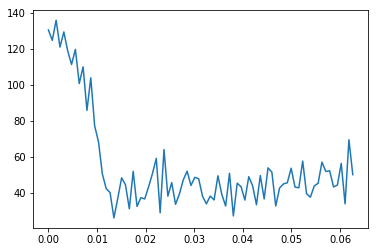

In [63]:
# first plot the whole graph
plt.plot(lrs[:80], losses[:80])
plt.show()

## Trainning with Triangular learning rate policy.

Before training with this policy you have to estimate the range of learning rates using previous function.

In [92]:
def get_triangular_lr(lr_low, lr_high, stepesize):
    delta = (lr_high - lr_low)/(stepesize -1)
    lrs1 = [lr_low + i*delta for i in range(stepesize)]
    lrs2 = [lr_high - i*delta for i in range(stepesize)]
    return lrs1+lrs2
lrs = get_triangular_lr(0, 1, 10)
print(lrs)

[0.0, 0.1111111111111111, 0.2222222222222222, 0.3333333333333333, 0.4444444444444444, 0.5555555555555556, 0.6666666666666666, 0.7777777777777777, 0.8888888888888888, 1.0, 1.0, 0.8888888888888888, 0.7777777777777778, 0.6666666666666667, 0.5555555555555556, 0.4444444444444444, 0.33333333333333337, 0.22222222222222232, 0.11111111111111116, 0.0]


In [93]:
def train_triangular_policy(model, lr_low=1e-5, lr_high=0.012, train_dl=train_dl):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = x.shape[0]
            x = Variable(x).cuda().float()
            y = Variable(y).cuda().float()
        
            out = model(x)
            loss = F.l1_loss(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.data[0])
        print("train loss", sum_loss/total)
        val_loss(model, valid_dl)
    return sum_loss/total

In [27]:
def val_loss(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    for i, (x, y) in enumerate(valid_dl):
        batch = x.shape[0]
        x = Variable(x).cuda().float()
        y = Variable(y).cuda().float()
        out = model(x)
        loss = F.l1_loss(out, y)
        sum_loss += batch*(loss.data[0])
        total += batch
    print("val loss", sum_loss/total)
    return sum_loss/total

In [94]:
model = Darknet([1, 2, 4, 6, 3]).cuda()

In [ ]:
from datetime import datetime

steps = 5
for i in range(steps):
    start = datetime.now() 
    loss = train_triangular_policy(model)
    end = datetime.now()
    t = 'Time elapsed {}'.format(end - start)
    print("loss ", loss, t)

train loss 47.81492664769332
val loss 50.820497226941974
train loss 34.456719563257614
val loss 106.66324394643543
train loss 32.98741410832325
val loss 42.03031718702566
train loss 30.40088057217885
val loss 28.03747675364023
loss  30.40088057217885 Time elapsed 0:23:23.546833
train loss 29.866798144145886
val loss 30.65906181456455
train loss 31.41654774672166
val loss 165.85775676972332
train loss 30.489497582235874
val loss 28.16718803635672
train loss 26.333746526035473
val loss 23.430043296904717
loss  26.333746526035473 Time elapsed 0:23:09.276457


In [29]:
model = Darknet([1, 2, 4, 6, 3]).cuda()

In [30]:
#training with different sizes
train_ds = BoneAgeDataset(train, )
valid_ds = BoneAgeDataset(valid, transforms=False)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [31]:
val_loss(model, valid_dl)

val loss 127.41255388857353


127.41255388857353

In [32]:
train_loop(model, epochs=5, lr=0.1, wd=0.0)

loss  36.051943618769876
val loss 2230.887192704203
Time elapsed (hh:mm:ss.ms) 0:04:58.174143
loss  34.26247251209838
val loss 67.41548247492379
Time elapsed (hh:mm:ss.ms) 0:04:58.656578
loss  32.56086358750867
val loss 35.08560381079363
Time elapsed (hh:mm:ss.ms) 0:05:00.517020
loss  30.502686672870485
val loss 43.3300501213104
Time elapsed (hh:mm:ss.ms) 0:04:59.409675
loss  29.400802684144562
val loss 29.88208171169877
Time elapsed (hh:mm:ss.ms) 0:05:01.639025


In [33]:
train_loop(model, epochs=5, lr=0.05, wd=0.0)

loss  26.790056487072185
val loss 36.53312387247108
Time elapsed (hh:mm:ss.ms) 0:05:02.305601
loss  24.897395214602973
val loss 23.333194682751262
Time elapsed (hh:mm:ss.ms) 0:04:59.239170
loss  23.117923590623892
val loss 22.78447825789546
Time elapsed (hh:mm:ss.ms) 0:05:00.757716
loss  22.058179287244524
val loss 58.56091494337138
Time elapsed (hh:mm:ss.ms) 0:05:00.380470
loss  20.83642287097893
val loss 53.05122436596041
Time elapsed (hh:mm:ss.ms) 0:05:01.268299


In [34]:
train_loop(model, epochs=10, lr=0.001, wd=0.0)

loss  18.769728582032265
val loss 18.231157384535134
Time elapsed (hh:mm:ss.ms) 0:05:01.891472
loss  18.222848597101276
val loss 17.53739280156159
Time elapsed (hh:mm:ss.ms) 0:05:01.011842
loss  17.988008011957735
val loss 17.346115292300315
Time elapsed (hh:mm:ss.ms) 0:05:00.574137
loss  17.778114131685882
val loss 17.242611563650037
Time elapsed (hh:mm:ss.ms) 0:05:02.567720
loss  17.752681375246997
val loss 17.099167015323744
Time elapsed (hh:mm:ss.ms) 0:05:01.129414
loss  17.53652510849545
val loss 16.891538346220255
Time elapsed (hh:mm:ss.ms) 0:04:59.387807
loss  17.33721687059027
val loss 16.997812402711606
Time elapsed (hh:mm:ss.ms) 0:05:03.421243
loss  17.271966746853273
val loss 16.85184250815722
Time elapsed (hh:mm:ss.ms) 0:05:01.769020
loss  17.21004746862724
val loss 16.730244767372803
Time elapsed (hh:mm:ss.ms) 0:05:01.548436
loss  17.105595987489906
val loss 16.693165075013223
Time elapsed (hh:mm:ss.ms) 0:05:01.735805


In [36]:
def save_model(m, p): torch.save(m.state_dict(), p)
p = PATH/"model001.pth"
save_model(model, p)

In [37]:
train_loop(model, epochs=10, lr=0.0005, wd=0.0)

loss  17.026376719516858
val loss 16.488996053479383
Time elapsed (hh:mm:ss.ms) 0:05:01.077558
loss  17.05449960697086
val loss 16.571430705446367
Time elapsed (hh:mm:ss.ms) 0:04:59.207299
loss  16.921460427216086
val loss 16.4304956198684
Time elapsed (hh:mm:ss.ms) 0:04:59.168719
loss  16.91544908630752
val loss 16.34874444382234
Time elapsed (hh:mm:ss.ms) 0:04:59.567036
loss  16.76635766613057
val loss 16.39350597448145
Time elapsed (hh:mm:ss.ms) 0:05:00.028754
loss  16.79882159059638
val loss 16.446618893144624
Time elapsed (hh:mm:ss.ms) 0:04:59.276431
loss  16.706213208229837
val loss 16.430429531221442
Time elapsed (hh:mm:ss.ms) 0:05:00.856810
loss  16.741053224023478
val loss 16.340888287319633
Time elapsed (hh:mm:ss.ms) 0:05:02.765025
loss  16.68847453359074
val loss 16.393545072103283
Time elapsed (hh:mm:ss.ms) 0:05:02.099902
loss  16.723176729881157
val loss 16.34010503407417
Time elapsed (hh:mm:ss.ms) 0:05:01.478853


In [38]:
p = PATH/"model0005.pth"
save_model(model, p)

In [42]:
train_loop(model, epochs=10, lr=0.0003, wd=0.000001)

loss  16.450828810491533
val loss 16.127390656558227
Time elapsed (hh:mm:ss.ms) 0:05:14.115557
loss  16.527406403065815
val loss 16.199378974091715
Time elapsed (hh:mm:ss.ms) 0:05:15.365699
loss  16.475459117059465
val loss 16.06067849566878
Time elapsed (hh:mm:ss.ms) 0:05:11.197584
loss  16.44754842058118
val loss 16.14038661847882
Time elapsed (hh:mm:ss.ms) 0:05:05.119362
loss  16.382451371166372
val loss 16.104058384422647
Time elapsed (hh:mm:ss.ms) 0:05:13.382352
loss  16.265305758160636
val loss 16.11882994195755
Time elapsed (hh:mm:ss.ms) 0:05:16.239145
loss  16.266914886057183
val loss 16.10359597792236
Time elapsed (hh:mm:ss.ms) 0:05:16.254050
loss  16.171423736702334
val loss 16.036041109265078
Time elapsed (hh:mm:ss.ms) 0:05:16.450352
loss  16.185297592152498
val loss 16.050088778079076
Time elapsed (hh:mm:ss.ms) 0:05:15.882275
loss  16.2207181771549
val loss 15.984323851746476
Time elapsed (hh:mm:ss.ms) 0:05:05.228401


## Saving and loading 

In [ ]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
model.load_state_dict(torch.load(p))
p = PATH/"model001.pth"
save_model(model, p)

# References

* https://www.16bit.ai/blog/ml-and-future-of-radiology
* https://stanfordmedicine.app.box.com/s/vhq1zop1867gr9rwnan4byj8lfxue173
* https://github.com/fastai/fastai/blob/master/courses/dl2/cifar10-darknet.ipynb